<a href="https://colab.research.google.com/github/amrutha00/Amazon-Electronics-Recommendation/blob/main/amazon_recomm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!pwd

/content


In [14]:
!pip install surprise

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [16]:
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import KNNWithMeans
from surprise import SVD

#**Load and Pre-Process the dataset**

In [17]:
dataset = pd.read_csv("./drive/MyDrive/amazon/Electronics.csv",names=['productId', 'userId','rating','timestamp'])

In [8]:
dataset.head()

,productId,userId,rating,timestamp
0,0060009810,A1N070NS9CJQ2I,5.0,1026864000
1,0060009810,A3P0KRKOBQK1KN,5.0,1025913600
2,0060009810,A192HO2ICJ75VU,5.0,1025654400
3,0060009810,A2T278FKFL3BLT,4.0,1025395200
4,0060009810,A2ZUXVTW8RXBXW,5.0,1025222400


In [18]:
dataset.drop(['timestamp'],axis=1,inplace=True)

In [19]:
dataset.shape

(20994353, 3)

In [20]:
dataset = dataset.iloc[0:5000000] #5million records

In [ ]:
dataset.dtypes

productId     object
userId        object
rating       float64
dtype: object

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   productId  object 
 1   userId     object 
 2   rating     float64
dtypes: float64(1), object(2)
memory usage: 114.4+ MB


In [ ]:
dataset.describe()['rating']

count    5.000000e+06
mean     4.102528e+00
std      1.346475e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [ ]:
dataset.isnull().sum()

productId    0
userId       0
rating       0
dtype: int64

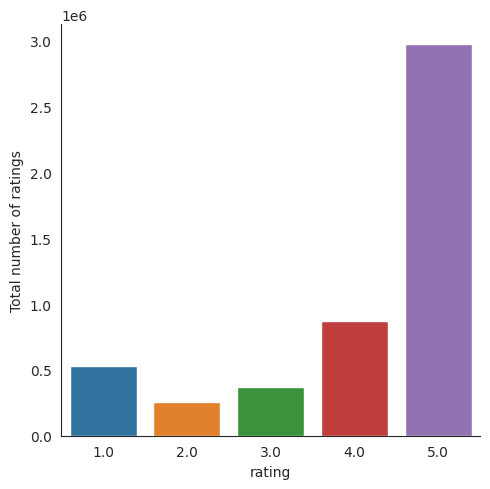

In [ ]:
with sns.axes_style('white'):
    g = sns.catplot(x="rating", data=dataset, kind='count', aspect=1.0)
    g.set_ylabels("Total number of ratings")


###**The ratings of products are skewed towards higher ratings**

In [ ]:
print("Total Records")
print("-"*50)
print("Total ratings: ",len(dataset))
print("Unique users: ",len(dataset.userId.unique()),len(dataset.userId.unique())/len(dataset)*100 )
print("Unique electronics: ",len(dataset.productId.unique()),len(dataset.productId.unique())/len(dataset)*100 )

Total Records
--------------------------------------------------
Total ratings:  5000000
Unique users:  2926618 58.532360000000004
Unique electronics:  50935 1.0187


In [ ]:
no_prod_per_user = dataset.groupby(by='userId')['productId'].count().sort_values(ascending = False)
no_prod_per_user.describe()

count    2.926618e+06
mean     1.708457e+00
std      1.977100e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.240000e+02
Name: productId, dtype: float64

In [ ]:
no_rating_per_product = dataset.groupby(by='productId')['rating'].count().sort_values(ascending=False)
no_rating_per_product.describe()

count    50935.000000
mean        98.164327
std        361.331804
min          1.000000
25%          7.000000
50%         21.000000
75%         66.000000
max      16046.000000
Name: rating, dtype: float64

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Products')

Text(0, 0.5, 'No of ratings per product')

[Text(-10000.0, 0, ''),
 Text(0.0, 0, ''),
 Text(10000.0, 0, ''),
 Text(20000.0, 0, ''),
 Text(30000.0, 0, ''),
 Text(40000.0, 0, ''),
 Text(50000.0, 0, ''),
 Text(60000.0, 0, '')]

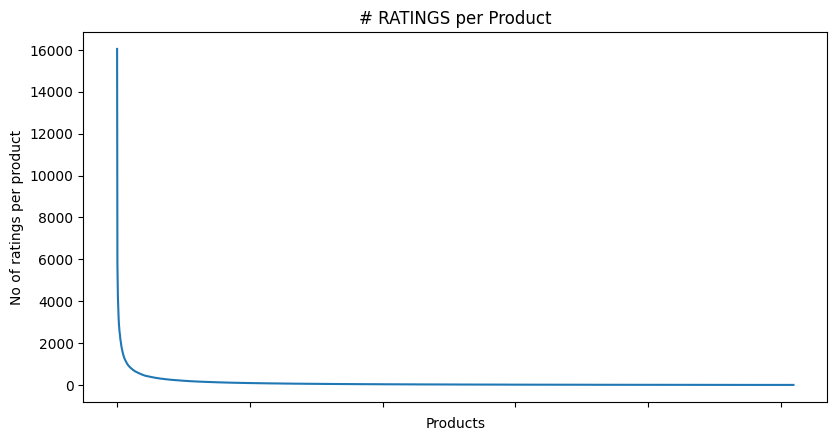

In [ ]:
fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_rating_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Products')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

### **Most products have around 1000 ratings**

In [ ]:
no_rating_per_product.iloc[0:776]

productId
B003L1ZYYW    16046
B0019HL8Q8    15389
B0019EHU8G    14133
B0015DYMVO    13836
B000BQ7GW8    13768
              ...  
B00066IJPQ     1002
B004EBG4J2     1002
B0013V1T2I     1000
B0019SSSMY     1000
B004V4IWKG      999
Name: rating, Length: 776, dtype: int64

###**The maximum number of ratings a product received is 16046**

##**Popularity based recommendation**
1. Select products that have atleast 1000 user ratings
2. Suggest the products in the order number of ratings

In [ ]:
df_pop = dataset[dataset.groupby('productId')['rating'].transform('count') >= 1000]
df_pop

,productId,userId,rating
2207,0972683275,A1KECIKIWDB4HH,4.0
2208,0972683275,A2MQ47BBL7F6B6,5.0
2209,0972683275,ANWW7PT6Z6MHD,5.0
2210,0972683275,A2DEU0B3AUINV9,5.0
2211,0972683275,AE8R1JSMJYIU,4.0
...,...,...,...
4999727,B004YI9NTS,A2V9DTXTQ5YIMK,5.0
4999728,B004YI9NTS,ADLVFFE4VBT8,2.0
4999729,B004YI9NTS,A32EOHLFZYXJEP,1.0
4999730,B004YI9NTS,A2UOHALGF2X77Q,5.0


In [ ]:
df_pop1 = df_pop.groupby('productId')['rating'].count().sort_values(ascending=False)
df_pop1

productId
B003L1ZYYW    16046
B0019HL8Q8    15389
B0019EHU8G    14133
B0015DYMVO    13836
B000BQ7GW8    13768
              ...  
B000XPS3U6     1004
B00066IJPQ     1002
B004EBG4J2     1002
B0019SSSMY     1000
B0013V1T2I     1000
Name: rating, Length: 775, dtype: int64

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Products')

Text(0, 0.5, 'No of ratings per product')

[Text(-100.0, 0, ''),
 Text(0.0, 0, ''),
 Text(100.0, 0, ''),
 Text(200.0, 0, ''),
 Text(300.0, 0, ''),
 Text(400.0, 0, ''),
 Text(500.0, 0, ''),
 Text(600.0, 0, ''),
 Text(700.0, 0, ''),
 Text(800.0, 0, ''),
 Text(900.0, 0, '')]

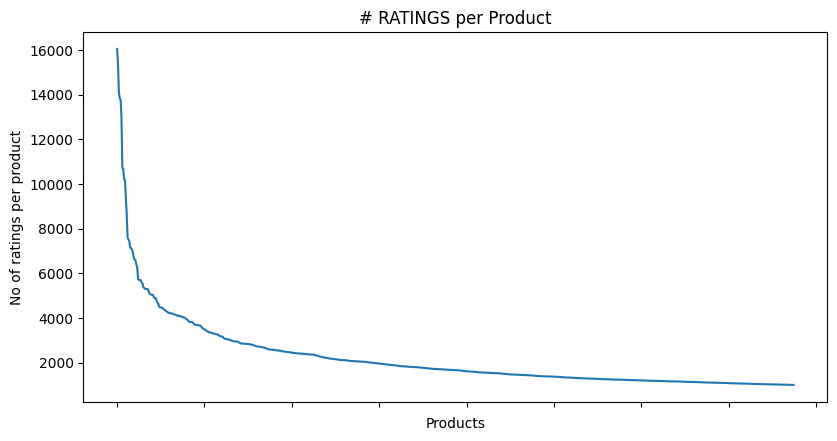

In [ ]:
fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(df_pop1.values)
plt.title('# RATINGS per Product')
plt.xlabel('Products')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

In [ ]:
df_pop.groupby('productId')['rating'].mean().sort_values(ascending=False).head()

productId
B004Y1AYAC    4.833522
B001AQYJI2    4.832660
B0000AKABP    4.829713
B0029N3U8K    4.813531
B001MSU1HG    4.813073
Name: rating, dtype: float64

In [ ]:
df_pop.groupby('productId')['rating'].count().sort_values(ascending=False).head()


productId
B003L1ZYYW    16046
B0019HL8Q8    15389
B0019EHU8G    14133
B0015DYMVO    13836
B000BQ7GW8    13768
Name: rating, dtype: int64

In [ ]:
ratings_mean_count = pd.DataFrame(df_pop.groupby('productId')['rating'].mean()) #each product compute the avg rating
ratings_mean_count['rating_counts'] = pd.DataFrame(df_pop.groupby('productId')['rating'].count()) #append a new column ratings count

In [ ]:
ratings_mean_count

,rating,rating_counts
productId,,
0972683275,4.518544,1456
1495443043,4.550194,1803
6073894996,3.229252,1217
9573212919,3.223214,1008
B00000K135,4.622174,1371
...,...,...
B004Y1AYAC,4.833522,1766
B004YAVF8I,4.306818,2464
B004YAYM06,3.873823,4248


<Figure size 800x600 with 0 Axes>

<Axes: >

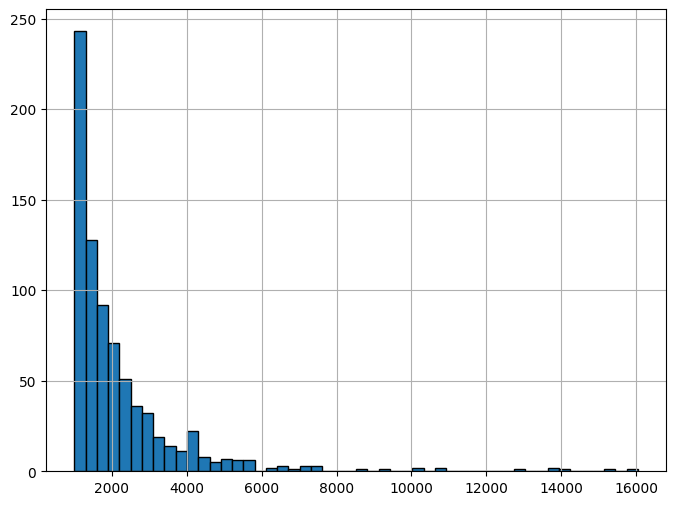

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

###**Off the records chosen for popularity based recommendation, about 85% of the records have ratings between 1000 and 4000**

<Figure size 800x600 with 0 Axes>

<Axes: >

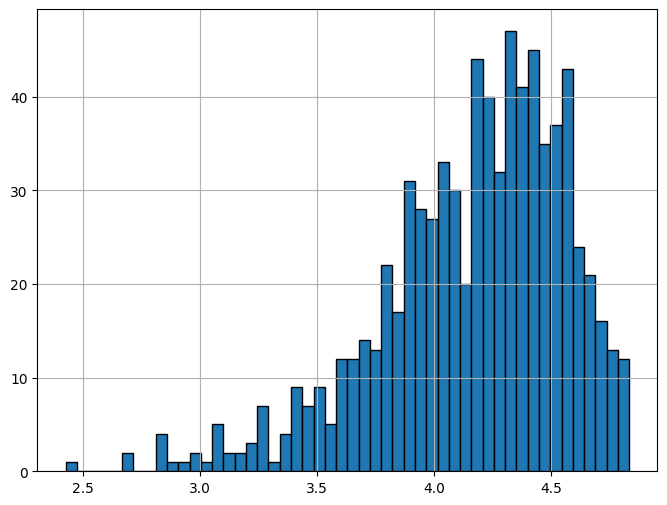

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)

###**Off the records chosen for popularity based recommendation, most records having rating between 4.0 - 4.5**

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

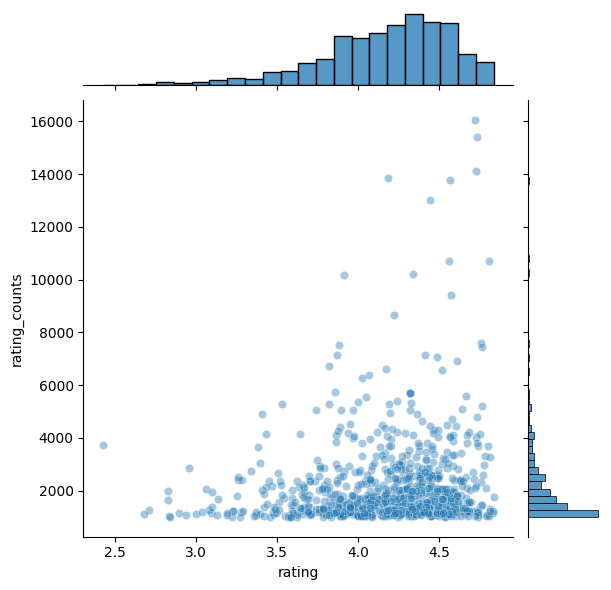

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

In [ ]:
most_popular = ratings_mean_count.sort_values(by='rating_counts',ascending=False)
most_popular

,rating,rating_counts
productId,,
B003L1ZYYW,4.719743,16046
B0019HL8Q8,4.732211,15389
B0019EHU8G,4.722493,14133
B0015DYMVO,4.185025,13836
B000BQ7GW8,4.562754,13768
...,...,...
B000XPS3U6,3.830677,1004
B00066IJPQ,3.784431,1002
B004EBG4J2,3.272455,1002


<Axes: xlabel='productId'>

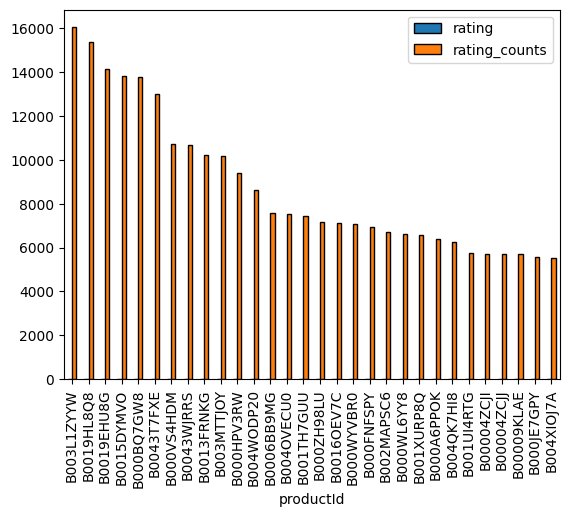

In [ ]:
most_popular.head(30).plot(kind = "bar")

##**Conclusion**

Products are recommended to users from a list of products with large number of ratings and those that are rated very high.

**Pros of Popularity based Recommendation**

*   No cold start problem
*   Simplicity of implementation
*   Scalable particulars when users increase
*   Promotes best sellers


**Cons of Popularity based Recommendation**

*   Lack of Personalization
*   Limited Diversity
*   Recommendations might not be of high quality
*   Suspectible to Manipulation through fake reviews






#**COLLABORATIVE FILTERING TECHNIQUES**

### We explore memory based and model based models

### Memory Based filtering:
###1. Item-Item collaborative filtering
###2. User-User collaborative filtering

### Model based filtering:
### 1. Matrix Factorization: Singular value decomposition

###**Evaluation Metrics Used**
####1. RMSE (Root Mean Squared Error) : It measures the average magnitude of the errors between predicted and actual ratings. A lower RMSE indicates better accuracy.
####2. MAE (Mean Absolute Error): It measures the average absolute difference between predicted and actual ratings. A lower MAE indicates better accuracy.

## **Item Based collaborative filtering**

### **Recommendations are made based on similarity between the items the user has interacted with and other items**

In [7]:
data_sample = dataset.sample(n=5000000, random_state=40)
data_sample

,productId,userId,rating
7090805,B008R79SCY,AS405OGM6FO10,4.0
7912543,B00AQMUE30,AK9DKOGU4W3JY,4.0
12390648,B00MXX28MK,A124JFKHGCZT19,5.0
14587350,B00Y4663GG,A3V6SLD09W73LY,5.0
13335818,B00R1EPGRA,A21AHNEW6LQYA3,2.0
...,...,...,...
3844475,B003A1U5K6,A27UP3CRSLUYJN,5.0
15917799,B016ZU2NNA,A318WI071IP7C1,2.0
7127860,B008BGXHRS,AASL5Z79EBRBG,5.0
16278816,B019E26WBA,A37P50BUMVQWYJ,4.0


In [ ]:
print("Total Records")
print("-"*50)
print("Total ratings: ",len(data_sample))
print("Unique users: ",len(data_sample.userId.unique()),len(dataset.userId.unique())/len(dataset)*100 )
print("Unique electronics: ",len(data_sample.productId.unique()),len(dataset.productId.unique())/len(dataset)*100 )

Total Records
--------------------------------------------------
Total ratings:  5000000
Unique users:  3546355 46.86343989738574
Unique electronics:  444785 3.6032975152889923


**Items to chosen to recommend if they atleast have 500 ratings. This aims to mitigate the impact of any outliers or individual biases by relying on a larger pool of ratings, thus providing more reliable and representative recommendations**

In [ ]:
df_ii = data_sample[data_sample.groupby('productId')['rating'].transform('count') >= 500]
df_ii

,productId,userId,rating
7090805,B008R79SCY,AS405OGM6FO10,4.0
13335818,B00R1EPGRA,A21AHNEW6LQYA3,2.0
16952169,B01DMHPT3U,AHTFUNJCN33NI,5.0
7301039,B0096M8VR2,A26YL8635II94Y,5.0
2863930,B001FA1O18,A2SM4OZXOEMTV1,5.0
...,...,...,...
16564828,B01BGTG41W,A2YD70I7JM96D2,5.0
4023035,B003MTTJOY,A1MGA8IIBN813P,2.0
4471266,B004CADY9I,A160QDBRS8IHF2,5.0
6194492,B006P88VSE,AINP447MSU9AF,5.0


In [ ]:
print("Total Records")
print("-"*50)
print("Total ratings: ",len(df_ii))
print("Unique users: ",len(df_ii.userId.unique()),len(dataset.userId.unique())/len(dataset)*100 )
print("Unique electronics: ",len(df_ii.productId.unique()),len(dataset.productId.unique())/len(dataset)*100 )

Total Records
--------------------------------------------------
Total ratings:  806600
Unique users:  716792 46.86343989738574
Unique electronics:  890 3.6032975152889923


In [ ]:
ratings_mean_count_ii = pd.DataFrame(df_ii.groupby('productId')['rating'].mean()) #each product compute the avg rating
ratings_mean_count_ii['rating_counts'] = pd.DataFrame(df_ii.groupby('productId')['rating'].count()) #append a new column ratings count

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

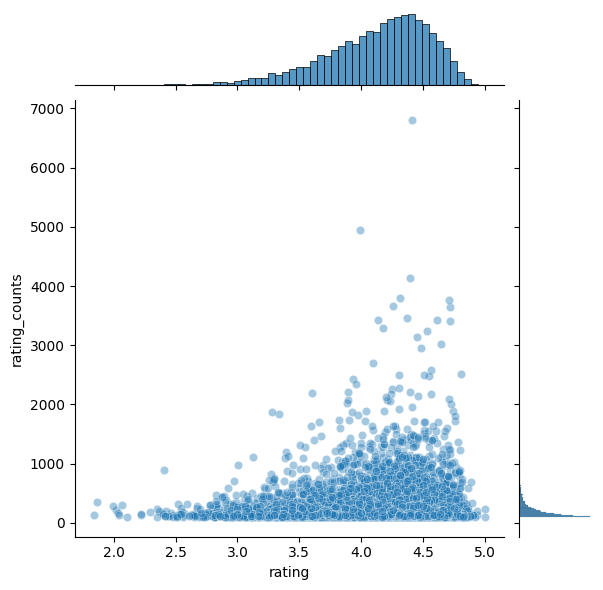

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count_ii, alpha=0.4)

In [ ]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_ii[['userId', 'productId', 'rating']],reader)
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [ ]:
# Create a KNNWithMeans collaborative filtering algorithm object with k=5 neighbors.
# The 'sim_options' parameter specifies the similarity metric to use ('pearson_baseline')
#and that item-based similarity should be used ('user_based': False).
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
train_pred = algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
similarity_matrix = algo.sim
similarity_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
train_pred = algo.test(trainset.build_testset())
rmse_train = accuracy.rmse(train_pred)
mae_train =  accuracy.mae(train_pred)
print("RMSE Train: ",rmse_train)
print("MAE Train: ",mae_train)

RMSE: 0.0106
MAE:  0.0003
RMSE Train:  0.010615011655134099
MAE Train:  0.00033293542824148396


In [ ]:
test_pred = algo.test(testset)
rmse_test = accuracy.rmse(test_pred, verbose=True)
mae_test = accuracy.mae(test_pred, verbose=True)
print("RMSE Test: ",rmse_test)
print("MAE Test: ",mae_test)

RMSE: 1.3099
MAE:  1.0160
RMSE Test:  1.3098997333525564
MAE Test:  1.0160405592844175


**Examples of Predictions using item-item based collaborative filtering**

In [ ]:
test_pred[:50]

[Prediction(uid='A1MDY4144RNG6', iid='B00005N6KG', r_ui=5.0, est=4.163845865402338, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A3SP4QLWCUBSD1', iid='B00CD1PTF0', r_ui=5.0, est=4.163845865402338, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1CY17NGZJBD9U', iid='B00WUIIH8W', r_ui=5.0, est=4.163845865402338, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AEPA819QATRIX', iid='B005ZA76YI', r_ui=5.0, est=4.163845865402338, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2W2J4MM2EPJ66', iid='B017GZND46', r_ui=4.0, est=4.163845865402338, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2CDW05RZPJTNU', iid='B005J7YA4G', r_ui=1.0, est=4.163845865402338, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2ICFSV5REN1B

##**Conclusion**

###**Accuracy**

**Training**

*   RMSE: 0.0106
*   MAE: 0.0003


**Testing**

*   RMSE: 1.3099
*   MAE: 1.0160


**Pros of Item based Recommendation**

*   Scalable as items are static relative to the number of users
*   Interpretable
*   Stable over time

**Cons of Item based Recommendation**

*   Cold Start Issue
*   Limited Seredipidity in recommendations for users with very few item interactions
*   Sparsity issue if items have very few ratings or user has very few interactions

## **User Based collaborative filtering**

### **Recommendations are made based on similarity between the users' past behaviors (ratings, purchases, etc.) and those of similar users, leveraging techniques such as Pearson correlation or cosine similarity**

**Sampling users with a minimum of 10 item interactions helps mitigate the cold start problem in recommendation systems by ensuring that recommendations are based on users with established preferences. This approach improves recommendation quality, reduces sparsity, and provides more stable and reliable recommendations by focusing on users who have demonstrated sufficient engagement with the system. By excluding users with fewer interactions, noise is minimized, leading to more accurate and personalized recommendations for active users**

In [ ]:
df_uu = data_sample[data_sample.groupby('userId')['rating'].transform('count') >= 10]
df_uu

,productId,userId,rating
13335818,B00R1EPGRA,A21AHNEW6LQYA3,2.0
2934079,B001ID829O,A3OFJES10PZGEH,5.0
2614132,B00193U3O0,A3SF7R5BRXPQJP,5.0
14553963,B00XXLUC5Q,A27BJ2Z80MLTYU,5.0
9651928,B001G45G3A,A1JX8MOFREFLHQ,5.0
...,...,...,...
6250125,B006U3O566,A35DXKKJWTVB7G,5.0
14990721,B01195T61S,AGYPU6TD7URMY,5.0
18857039,B0098ET91K,A26C28HX56U35E,4.0
4023035,B003MTTJOY,A1MGA8IIBN813P,2.0


In [ ]:
print("Total Records")
print("-"*50)
print("Total ratings: ",len(df_uu))
print("Unique users: ",len(df_uu.userId.unique()),len(dataset.userId.unique())/len(dataset)*100 )
print("Unique electronics: ",len(df_uu.productId.unique()),len(dataset.productId.unique())/len(dataset)*100 )

Total Records
--------------------------------------------------
Total ratings:  258523
Unique users:  22207 46.86343989738574
Unique electronics:  93092 3.6032975152889923


In [ ]:
ratings_mean_count_uu = pd.DataFrame(df_uu.groupby('userId')['rating'].mean()) #each product compute the avg rating
ratings_mean_count_uu['rating_counts'] = pd.DataFrame(df_uu.groupby('userId')['rating'].count()) #append a new column ratings count

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

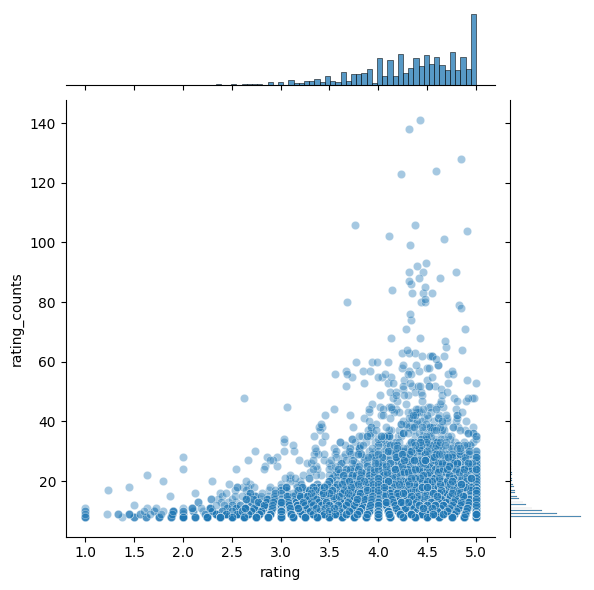

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count_uu, alpha=0.4)

In [ ]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_uu[['userId', 'productId', 'rating']],reader)
trainset_uu, testset_uu = train_test_split(data, test_size=0.3,random_state=10)

In [ ]:
#user-user
# Create a KNNWithMeans collaborative filtering algorithm object with k=5 neighbors.
# The 'sim_options' parameter specifies the similarity metric to use ('pearson_baseline')
#and that user-based similarity should be used ('user_based': True).
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline','user_based' :True})
algo.fit(trainset_uu)

Estimating biases using als...


In [ ]:
train_pred_uu = algo.test(trainset_uu.build_testset())
rmse_train_uu = accuracy.rmse(train_pred_uu)
mae_train_uu =  accuracy.mae(train_pred_uu)
print("RMSE Train: ",rmse_train_uu)
print("MAE Train: ",mae_train_uu)

RMSE: 0.0177
MAE:  0.0007
RMSE Train:  0.01771878408667691
MAE Train:  0.0007184534761383462


In [ ]:
test_pred_uu = algo.test(testset_uu)
rmse_test_uu = accuracy.rmse(test_pred_uu)
mae_test_uu =  accuracy.mae(test_pred_uu)
print("RMSE Test: ",rmse_test_uu)
print("MAE Test: ",mae_test_uu)

RMSE: 1.0754
MAE:  0.7650
RMSE Test:  1.0754301725777788
MAE Test:  0.764986499765523


In [ ]:
test_pred_uu

[Prediction(uid='A3P16J0AFQ32LI', iid='B0105VIVVI', r_ui=5.0, est=4.335245357811726, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A376YW43PUSHG4', iid='B00DEJXRAE', r_ui=4.0, est=3.727272727272727, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2PL06HW6KZH2', iid='B0006BB9MG', r_ui=5.0, est=4.999811463082614, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='AT38WPFUKPKCE', iid='B0024R4B5C', r_ui=1.0, est=4.375, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='ARBKYIVNYWK3C', iid='B009A6CZYY', r_ui=4.0, est=4.407407407407407, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1S68T2VGI4A72', iid='B0001XFLTQ', r_ui=5.0, est=4.642857142857143, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1VGHTDOZXOOYP', iid='B00WZ2H0N6', r_ui=5.0, est=4.335245357811726, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction

##**Conclusion**

###**Accuracy**

**Training**

*   RMSE: 0.0177
*   MAE: 0.0007


**Testing**

*   RMSE: 1.0754
*   MAE: 0.7650


**Pros of User based Recommendation**

*   Effective Handling of Cold Start Problem
*   Accounting for Contextual Preferences (demography,)
*   Enhanced Diversity
*   Discovery of Niche Items


**Cons of User based Recommendation**

*   Scalability
*   Sparsity
*   Privacy concerns

#**Model Based Collaborative Filtering - SVD**

In [21]:
data_svd = dataset.sample(n=1000000, random_state=10)
data_svd

,productId,userId,rating
2726450,B001CBFTFM,A2TPZW2V21LH2R,5.0
331317,B00007KDX6,A1PHUKXIVBYKVN,5.0
2184531,B000VOU91U,A3KKJH4EZAAHPQ,5.0
3967752,B003L1ZYYW,AQF1HH625PZQ0,5.0
1455729,B000MSDL6K,A3G6N66V3T62YA,5.0
...,...,...,...
3084613,B001PKTFM8,A1JPBFHUPJJLZ0,5.0
4416143,B004AC0L4Y,A3KTWM533LXHF6,5.0
1171737,B000FFQ1VM,A34M3XJLYV0YJI,5.0
1961223,B0012UUP02,A36GI4GGNAMEEL,5.0


In [22]:
print("Total Records")
print("-"*50)
print("Total ratings: ",len(data_svd))
print("Unique users: ",len(data_svd.userId.unique()))
print("Unique electronics: ",len(data_svd.productId.unique()) )

Total Records
--------------------------------------------------
Total ratings:  1000000
Unique users:  832534
Unique electronics:  43356


In [23]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(data_svd[['userId', 'productId', 'rating']],reader)

In [24]:
# Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.25,random_state=0)

In [25]:
algo = SVD()
algo.fit(trainset)

In [26]:
train_pred = algo.test(trainset.build_testset())
test_pred = algo.test(testset)

In [27]:
RMSE_SVD_train = accuracy.rmse(train_pred)
RMSE_SVD_test = accuracy.rmse(test_pred)

RMSE: 0.8006
RMSE: 1.2688


In [28]:
para_grid = {
    'n_epochs': [5, 10],   # number of epochs
    'lr_all': [0.002, 0.005],  # learning rate
    'reg_all': [0.4, 0.6]  # regularization term
}

# Setup GridSearchCV for SVD
gs = GridSearchCV(SVD, para_grid, measures=['rmse'], cv=3)

# Fit the data
gs.fit(data)

In [29]:
# Print the best RMSE score
print('Best RMSE:', gs.best_score['rmse'])

# Print the best parameters
print('Best parameters:', gs.best_params['rmse'])

Best RMSE: 1.2844789237191396
Best parameters: {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


**Examples of Predictions using SVD**

In [30]:
import random


random.seed(0)
random_test_samples = random.sample(testset, 25)

predictions = [algo.predict(uid, iid, r_ui) for (uid, iid, r_ui) in random_test_samples]
# Display the actual and predicted ratings
for prediction in predictions:
    print(f"User: {prediction.uid}, Item: {prediction.iid}, Actual Rating: {prediction.r_ui}, Predicted Rating: {prediction.est:.2f}")

User: A24LD9GCC60VIJ, Item: B00063EG9M, Actual Rating: 5.0, Predicted Rating: 4.26
User: A33D03JW1QJHY8, Item: B003MTTJOY, Actual Rating: 3.0, Predicted Rating: 3.65
User: AQDJ3Y7EFLFXO, Item: B0015453PM, Actual Rating: 5.0, Predicted Rating: 4.49
User: A2VCANK5PX024R, Item: B0015HOFZI, Actual Rating: 4.0, Predicted Rating: 4.03
User: A31GFK2WVO5904, Item: B002KEYYE2, Actual Rating: 5.0, Predicted Rating: 4.71
User: A2JQVUUME7GBG1, Item: B001PBYQHG, Actual Rating: 4.0, Predicted Rating: 4.59
User: AP9VJ97S7V06D, Item: B001JG2VO2, Actual Rating: 4.0, Predicted Rating: 3.99
User: AR9WANWTTKJH9, Item: B002LZMY10, Actual Rating: 5.0, Predicted Rating: 3.49
User: A2L1PZJ86F50GM, Item: B001O0V8HE, Actual Rating: 3.0, Predicted Rating: 3.71
User: A20SAXXPY2PHJ2, Item: B00176T9OY, Actual Rating: 5.0, Predicted Rating: 4.36
User: A6YQ7R55EB2O3, Item: B001NIZB5M, Actual Rating: 5.0, Predicted Rating: 3.72
User: AHCLJ2082GBE2, Item: B000R9J5OG, Actual Rating: 1.0, Predicted Rating: 4.50
User: A2X

##**Conclusion**

###**Accuracy**

**Training**

*   RMSE: 0.8066

**Testing**

*   RMSE: 1.2688

**Grid Search Parameters and Accuracy**

*   Epochs: 10
*   Learning Rate: 0.005
*   Regularization: 0.4
*   RMSE: 1.2844

**Pros of User based Recommendation**

*   Accounts for latent factors and provides global optimization
*   Robustness to Noise
*   Better at handling the cold start problem


**Cons of User based Recommendation**

*   Scalability to Large Datasets
*   Overfitting Potential